#FORECASTING PENJUALAN HARIAN

## Load Data & Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
import warnings

from google.colab import drive

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from matplotlib.ticker import FuncFormatter, ScalarFormatter

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm


In [ ]:
drive.mount('/content/drive')
path_data = '/content/drive/My Drive/MSIB/Project_Kelompok/dataset/'
os.listdir(path_data)

Mounted at /content/drive


['dataset.csv',
 'dataset.gsheet',
 'dataset_kurir.csv',
 'data_feature.gsheet',
 'dataset_case5.gsheet',
 'dataset_case5.csv',
 'Data_Feature.csv',
 'temp_data',
 'Data_Feature_Add_Column.csv',
 'data feature.csv']

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.read_csv(path_data + 'Data_Feature_Add_Column.csv')

## EDA

In [ ]:
df.head()

,Waktu Pembaruan,Sinkronisasi Terakhir,Tanggal Pembuatan,Jenis Pesanan,Channel,Nama Toko,Pembayaran,Waktu Pembayaran,Waktu Pengiriman,Waktu Penyelesaian,Variant Produk,Harga Awal Produk,Total Berat(g),Subtotal,Kota,Total,Biaya Pengiriman,Biaya Kirim Ditanggung Pembeli,Asuransi,Total Diskon,Biaya Komisi,Biaya Layanan,Ongkir Dibayar Sistem,Potongan Biaya Pengiriman,Koin,Voucher Channel,Diskon Penjual,Alasan Pembatalan,SKU_1,SKU_2,SKU_3,SKU_4,SKU_5,SKU_6,SKU_7,SKU_8,SKU_9,SKU_10,SKU_11,SKU_12,ID Pesanan Hashed,is_diskon,Jumlah_SKU,Year,Month,WeekOfYear,WeekOfMonth,MonthWeekLabel,Day,Hour,Minute,Nama_hari
0,2024-05-15 09:32:00,2024-05-15 09:35:00,14-05-2024 11:29,Pesanan Normal,Toko Ijo,Toko 1,Online Payment,2024-05-14 11:52:00,2024-05-14 13:40:00,2024-05-15 09:32:00,COMBO (500ML+330ML),989800.0,650.0,890820.0,KOTA DEPOK,829152.0,0.0,29500.0,0.0,0.0,-35633.0,-26035.0,-29500.0,20000.0,0.0,89082.0,0.0,Others / change of mind,103.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747909763bd0341883eb2726872231248ee39bdf9d6fbf...,Ya,2,2024,5,20,3,2024-M5-W3,2024-05-14,11,52,Selasa
1,2024-05-14 17:45:00,2024-05-14 13:09:00,14-05-2024 10:19,Pesanan Normal,Toko Biru,Toko 2,Bank 1,2024-05-14 10:19:00,2024-05-14 13:40:00,2024-05-15 09:32:00,1PC,99900.0,250.0,99900.0,Kota Administrasi Jakarta Selatan,135800.0,35000.0,0.0,900.0,23993.0,0.0,0.0,0.0,17000.0,0.0,6993.0,0.0,Others / change of mind,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d85e99b5b5713d2cbdfaba295c3d2041d820a6b01c40bf...,Tidak,1,2024,5,20,3,2024-M5-W3,2024-05-14,10,19,Selasa
2,2024-05-15 06:05:00,2024-05-15 06:05:00,14-05-2024 08:16,Pesanan Normal,Toko Ijo,Toko 3,Digital Wallet,2024-05-14 08:16:00,2024-05-14 13:40:00,2024-05-15 06:05:00,1pc,39900.0,250.0,39900.0,KOTA SURABAYA,35431.0,0.0,0.0,0.0,0.0,-1596.0,-2873.0,0.0,9000.0,0.0,0.0,0.0,Others / change of mind,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e1749e58062288683656be54ff11cf2ac8212c9ad8e0ba...,Ya,1,2024,5,20,3,2024-M5-W3,2024-05-14,8,16,Selasa
3,2024-05-15 11:22:00,2024-05-15 11:27:00,14-05-2024 07:34,Pesanan Normal,Toko Ijo,Toko 3,Digital Wallet,2024-05-14 07:34:00,2024-05-14 13:40:00,2024-05-15 11:22:00,1pc,99900.0,250.0,99900.0,KOTA SURABAYA,88711.0,0.0,0.0,0.0,0.0,-3996.0,-7193.0,0.0,6500.0,0.0,0.0,0.0,Others / change of mind,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5b7bcb467b8de93f4e7bfd84bdfe4fbd5407fdc512d3c6...,Ya,1,2024,5,20,3,2024-M5-W3,2024-05-14,7,34,Selasa
4,2024-05-14 14:03:00,2024-05-14 14:09:00,13-05-2024 12:44,Pesanan Normal,Toko Ijo,Toko 1,Digital Wallet,2024-05-13 12:45:00,2024-05-13 16:39:00,2024-05-14 14:03:00,100ML + 300ML,139800.0,500.0,128616.0,KOTA TANGERANG,110224.0,0.0,0.0,0.0,0.0,-10932.0,-7460.0,0.0,9000.0,0.0,19293.0,0.0,Others / change of mind,137.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52fb6e8e534ce863ef8b4613a80d05495b449ac69cc396...,Ya,2,2024,5,20,3,2024-M5-W3,2024-05-13,12,45,Senin


In [ ]:
df['Day'] = pd.to_datetime(df['Day'])

## Feature Engineering

### Ngubah MonthWeekLabel & Membuat data untuk Forecast

1. 2024-M2-W5 digabung dengan 2024-M3-W1 menjadi 1 minggu di 2024-M3-W1
2. 2024-M4-W5 digabung dengan 2024-M5-W1 menjadi minggu di 2024-M5-W1

In [ ]:
# Membuat df_forecast
df_forecast = df.groupby('Day')['Total'].sum().reset_index()
df_forecast

,Day,Total
0,2024-02-15,6150932.0
1,2024-02-16,8176135.0
2,2024-02-17,11621019.0
3,2024-02-18,7301709.0
4,2024-02-19,10063115.0
5,2024-02-20,5993606.0
6,2024-02-21,7650572.0
7,2024-02-22,7252029.0
8,2024-02-23,3898784.0
9,2024-02-24,7943531.0


## Visualisasi Pendapatan Penjualan Harian

In [ ]:
figure = px.line(df_forecast, x = 'Day', y = 'Total', title = "Pendapatan Penjualan Harian")
figure.show()

<Figure size 640x480 with 0 Axes>

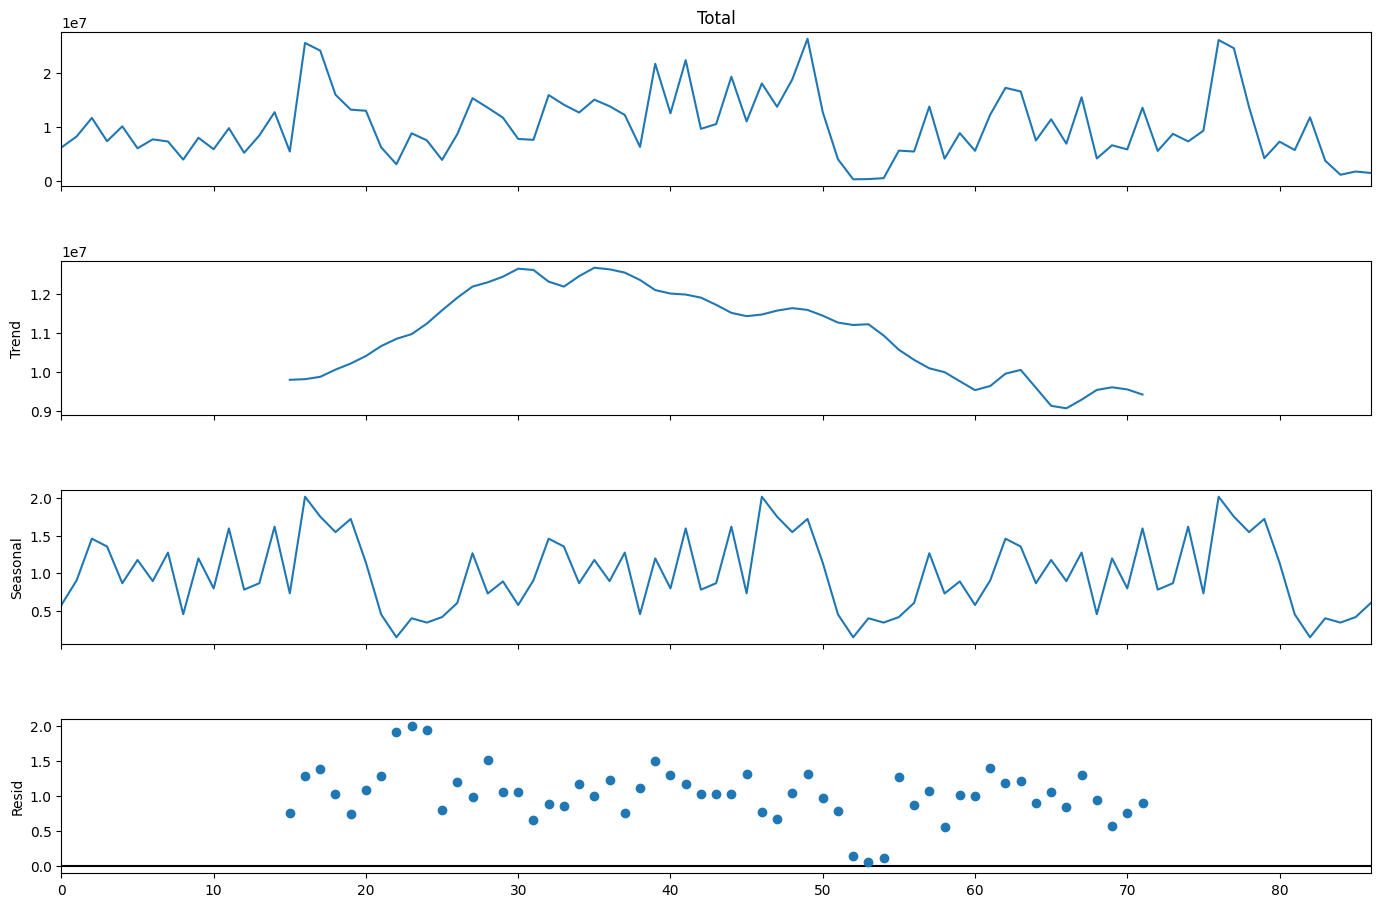

In [ ]:
result = seasonal_decompose(df_forecast['Total'], model = 'multiplicative', period = 30)
fig = plt.figure()
fig  = result.plot()
fig.set_size_inches(15,10)

## Menentukan Nilai d,p,q Untuk FORECASTING ARIMAX

Dari hasil visualisasi di atas, hasil dari lineplot kita itu sama dengan bagian visualiasi Seasonal

***maka nilai d nya = 1***

dan setelah itu mencari nilai p menggunakan plot (autocorrelation)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

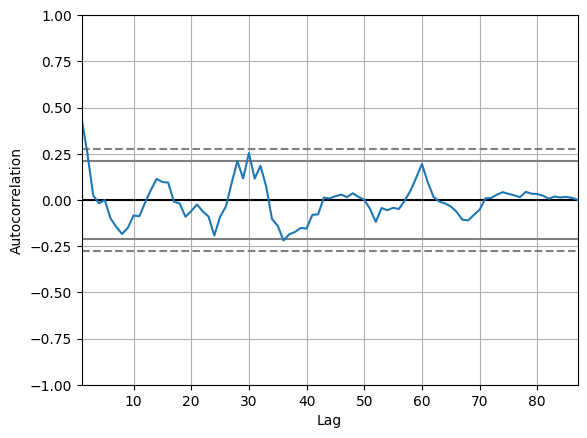

In [ ]:
pd.plotting.autocorrelation_plot(df_forecast['Total'])

karena hasil visualisasi kita memotong 4 garis

***maka nilai p = 4***

setelah itu Mencari nilai q menggunakan autocorrelation partial

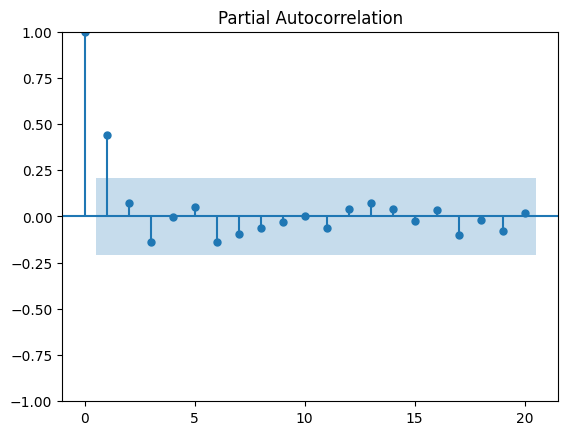

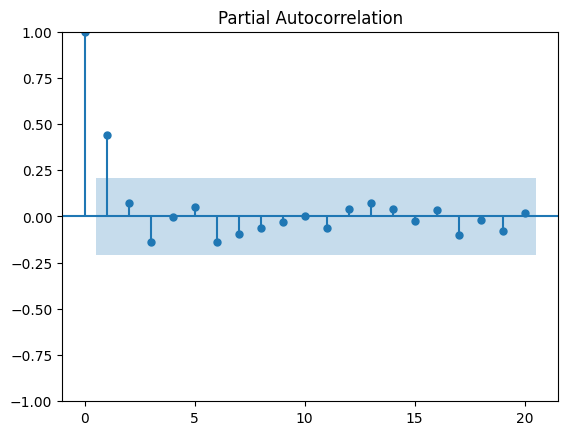

In [ ]:
plot_pacf(df_forecast['Total'], lags = 20) # lags = 20 adalah nilai tertinggi dari sumbu X adalah 20

Dari visualisasi dapat terlihat bahwa terdapat 2 titik yang paling jauh

***Maka nilai q = 2***

In [ ]:
d = 1 #(karena seasonal)
p = 4 #(karena memotong 4 garis)
q = 2 #(karena terdapat 2 titik yang terjauh)

## Membangun Model

In [ ]:
model = sm.tsa.statespace.SARIMAX(df_forecast['Total'],
                                 order=(3, d, q),  #(3 dapet dari nilai p yang tak kurangin 1), sebenarnya itu harusnya (p,d,q)
                                 seasonal_order=(p, d, q, 4))  # Lag musiman (p, d, q, 4)
model = model.fit()
print(model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             Total   No. Observations:                   87
Model:             SARIMAX(3, 1, 2)x(4, 1, 2, 4)   Log Likelihood               -1409.316
Date:                           Thu, 06 Jun 2024   AIC                           2842.632
Time:                                   09:17:58   BIC                           2871.513
Sample:                                        0   HQIC                          2854.227
                                            - 87                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3242      8.666      0.037      0.970     -16.661      17.309
ar.L2          0.1015      3.287      0.031

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Prediksi Model

In [ ]:
# Perkiraan Pendapatan 10 hari kedepan
predictions = model.predict(len(df_forecast), len(df_forecast)+9)
print(predictions)

87    5.326125e+06
88    5.151977e+06
89    7.315205e+06
90    4.571600e+06
91    5.071082e+06
92    7.653480e+06
93    8.580844e+06
94    5.205189e+06
95    3.566918e+06
96    3.750106e+06
Name: predicted_mean, dtype: float64


## Output Hasil Prediksi Model

In [ ]:

# Membuat DataFrame untuk prediksi
predicted_dates = pd.date_range(start=df_forecast['Day'].max() + pd.Timedelta(days=1), periods=len(predictions), freq='D')
predicted_df = pd.DataFrame({'Day': predicted_dates, 'Total': predictions})

# Menggabungkan DataFrame
combined_df = pd.concat([df_forecast, predicted_df], ignore_index=True)

# Visualisasi menggunakan Plotly Express
figure = px.line(combined_df, x='Day', y='Total', title="Pendapatan Penjualan Harian + prediksi 10 hari kedepan", template='plotly_white')

# Menandai area di bawah kurva prediksi dengan warna orange
figure.add_trace(go.Scatter(x=predicted_df['Day'].tolist() + predicted_df['Day'].tolist()[::-1],
                             y=predicted_df['Total'].tolist() + [0] * len(predicted_df),
                             fill='toself',
                             fillcolor='rgba(255, 165, 0, 0.2)',
                             line=dict(color='rgba(255, 165, 0, 0)'),
                             name='Prediksi'))

# Menambahkan annotation
figure.add_annotation(x=predicted_df['Day'].mean(), y=predicted_df['Total'].min(),
                      text="Prediksi",
                      showarrow=False,
                      font=dict(size=12, color="black"),
                      bgcolor="orange",
                      opacity=0.8,
                      xanchor="center", yanchor="top")

figure.show()
